## Dependencies

In [1]:
import os, glob, warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from transformers import TFDistilBertModel
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

def seed_everything(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

In [2]:
# Auxiliary functions
def plot_metrics(history, metric_list):
    fig, axes = plt.subplots(len(metric_list), 1, sharex='col', figsize=(20, 18))
    axes = axes.flatten()
    
    for index, metric in enumerate(metric_list):
        axes[index].plot(history[metric], label='Train %s' % metric)
        axes[index].plot(history['val_%s' % metric], label='Validation %s' % metric)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric)

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()
    
def plot_confusion_matrix(y_train, train_pred, y_valid, valid_pred, labels=[0, 1]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    train_cnf_matrix = confusion_matrix(y_train, train_pred)
    validation_cnf_matrix = confusion_matrix(y_valid, valid_pred)

    train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
    validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

    train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
    validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

    sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
    sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8),ax=ax2).set_title('Validation')
    plt.show()

# Datasets
def get_training_dataset():
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset():
    dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

## TPU configuration

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [4]:
dataset_base_path = '/kaggle/input/jigsaw-dataset-toxic-distilbert/'
dataset_base_bias_pt1_path = '/kaggle/input/jigsaw-dataset-bias-distilbert-pt1/'
dataset_base_bias_pt2_path = '/kaggle/input/jigsaw-dataset-bias-distilbert-pt2/'

x_train_bias_path = glob.glob(dataset_base_bias_pt1_path + 'x_train*.npy')
x_train_bias_path += glob.glob(dataset_base_bias_pt2_path + 'x_train*.npy')
x_train_bias_path.sort()

y_train_bias_path = glob.glob(dataset_base_bias_pt1_path + 'y_train*.npy')
y_train_bias_path += glob.glob(dataset_base_bias_pt2_path + 'y_train*.npy')
y_train_bias_path.sort()

x_valid_path = dataset_base_path + 'x_valid.npy'
y_valid_path = dataset_base_path + 'y_valid.npy'

x_train = np.load(x_train_bias_path[0])
for path_pt in x_train_bias_path[1:3]:
    x_train = np.vstack([x_train, np.load(path_pt)])

y_train = np.load(y_train_bias_path[0])
for path_pt in y_train_bias_path[1:3]:
    y_train = np.vstack([y_train, np.load(path_pt)])

x_valid = np.load(x_valid_path)
y_valid = np.load(y_valid_path)

print('Train samples %d' % len(x_train))
print('Validation samples %d' % len(x_valid))

Train samples 300000
Validation samples 8000


# Model parameters

In [5]:
MAX_LEN = 512
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
EPOCHS = 20
LEARNING_RATE = 1e-5 # * strategy.num_replicas_in_sync
ES_PATIENCE = 5
TRAIN_STEPS = len(x_train) // BATCH_SIZE
VALIDATION_STEPS = len(x_valid) // BATCH_SIZE

base_model_path = '/kaggle/input/diltilbert-base-ml-cased-huggingface/distilbert-base-multilingual-cased-tf_model.h5'
config_path = '/kaggle/input/diltilbert-base-ml-cased-huggingface/distilbert-base-multilingual-cased-config.json'
model_path = 'model.h5'

# Learning rate schedule

Learning rate schedule: 1e-09 to 1e-05 to 1.4e-06


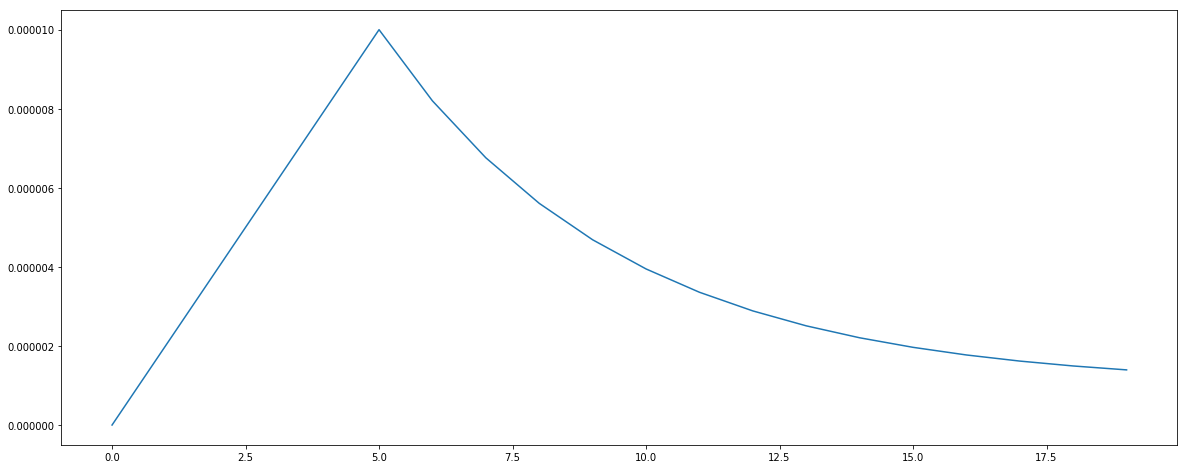

In [6]:
LR_START = 1e-9
LR_MIN = 1e-6
LR_MAX = LEARNING_RATE
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [7]:
def model_fn():
    input_word_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
    base_model = TFDistilBertModel.from_pretrained(base_model_path, config=config_path)
    sequence_output = base_model(input_word_ids)[0]
    
    x = GlobalAveragePooling1D()(sequence_output)
    x = Dropout(0.25)(x)
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=input_word_ids, outputs=output)
    model.compile(optimizers.Adam(lr=LEARNING_RATE), 
                  loss=losses.BinaryCrossentropy(), 
                  metrics=[metrics.BinaryAccuracy(), metrics.AUC()])
    
    return model

with strategy.scope():
    model = model_fn()
    
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist ((None, 512, 768),)       134734080 
_________________________________________________________________
global_average_pooling1d (Gl (None, 768)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 768)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 769       
Total params: 134,734,849
Trainable params: 134,734,849
Non-trainable params: 0
_________________________________________________________________


# Train

In [8]:
STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, 
                   restore_best_weights=True, verbose=1)
lr_callback = LearningRateScheduler(lrfn, verbose=1)

history = model.fit(x=get_training_dataset(),
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=get_validation_dataset(),
                    callbacks=[es, lr_callback],
                    epochs=EPOCHS, 
                    verbose=1).history

model.save_weights(model_path)

Train for 585 steps, validate for 15 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-09.
Epoch 1/20
585/585 [==============================] - 390s 666ms/step - loss: 0.7553 - binary_accuracy: 0.2667 - auc: 0.4928 - val_loss: 0.7043 - val_binary_accuracy: 0.3934 - val_auc: 0.5089

Epoch 00002: LearningRateScheduler reducing learning rate to 2.0008e-06.
Epoch 2/20
585/585 [==============================] - 341s 582ms/step - loss: 0.3335 - binary_accuracy: 0.7079 - auc: 0.5248 - val_loss: 0.4380 - val_binary_accuracy: 0.8456 - val_auc: 0.5191

Epoch 00003: LearningRateScheduler reducing learning rate to 4.0005999999999994e-06.
Epoch 3/20
585/585 [==============================] - 341s 582ms/step - loss: 0.2935 - binary_accuracy: 0.7088 - auc: 0.7059 - val_loss: 0.3999 - val_binary_accuracy: 0.8413 - val_auc: 0.7060

Epoch 00004: LearningRateScheduler reducing learning rate to 6.000399999999999e-06.
Epoch 4/20
585/585 [==============================] - 339s 580ms/st

## Model loss graph

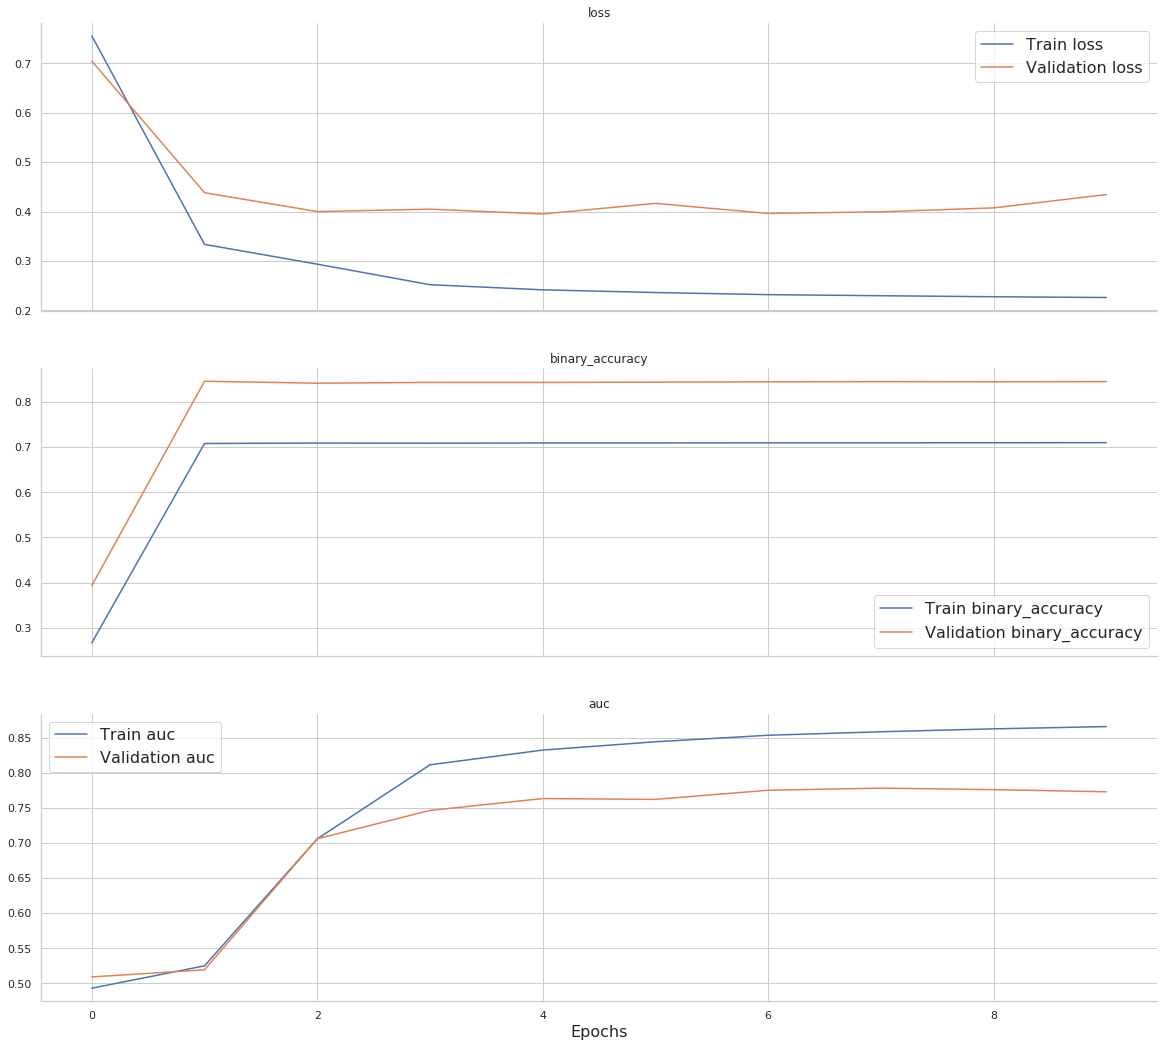

In [9]:
sns.set(style="whitegrid")
plot_metrics(history, metric_list=['loss', 'binary_accuracy', 'auc'])

# Model evaluation

In [10]:
train_pred = model.predict(get_training_dataset(), steps=TRAIN_STEPS)
valid_pred = model.predict(get_validation_dataset())

print('Train set ROC AUC %.4f' % roc_auc_score(np.round(y_train[:len(train_pred)]), np.round(train_pred)))
print(classification_report(np.round(y_train[:len(train_pred)]), np.round(train_pred)))
print('Validation set ROC AUC %.4f' % roc_auc_score(y_valid[:len(valid_pred)], np.round(valid_pred)))
print(classification_report(y_valid[:len(valid_pred)], np.round(valid_pred)))

Train set ROC AUC 0.5021
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93    281880
         1.0       0.06      0.08      0.07     17640

    accuracy                           0.87    299520
   macro avg       0.50      0.50      0.50    299520
weighted avg       0.89      0.87      0.88    299520

Validation set ROC AUC 0.5287
              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91      6494
         1.0       0.45      0.07      0.13      1186

    accuracy                           0.84      7680
   macro avg       0.65      0.53      0.52      7680
weighted avg       0.79      0.84      0.79      7680



# Confusion matrix

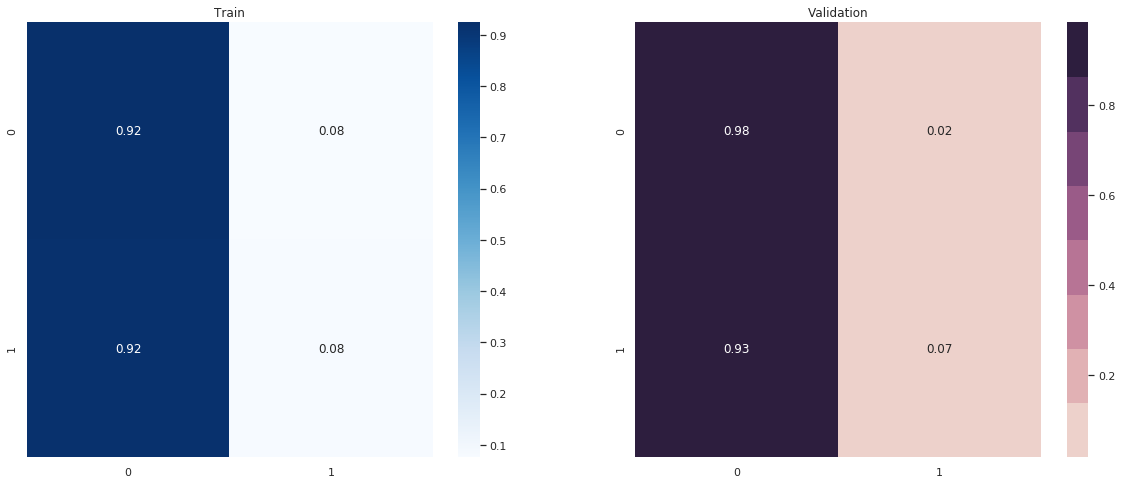

In [11]:
plot_confusion_matrix(np.round(y_train[:len(train_pred)]), np.round(train_pred), 
                      y_valid[:len(valid_pred)], np.round(valid_pred))

# Visualize predictions

In [12]:
train = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv", 
                    usecols=['comment_text', 'toxic'], nrows=10)
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv', 
                    usecols=['comment_text', 'toxic'], nrows=10)
train['pred'] = train_pred[:len(train)]
valid['pred'] = valid_pred[:len(valid)]

print('Train set')
display(train[['comment_text', 'toxic', 'pred']].head(10))
print('Validation set')
display(valid[['comment_text', 'toxic', 'pred']].head(10))

Train set


,comment_text,toxic,pred
0,"This is so cool. It's like, 'would you want yo...",0.000000,0.074096
1,Thank you!! This would make my life a lot less...,0.000000,0.090328
2,This is such an urgent design problem; kudos t...,0.000000,0.125848
3,Is this something I'll be able to install on m...,0.000000,0.032397
4,haha you guys are a bunch of losers.,0.893617,0.007677
5,ur a sh*tty comment.,0.666667,0.711157
6,hahahahahahahahhha suck it.,0.457627,0.019656
7,FFFFUUUUUUUUUUUUUUU,0.000000,0.030836
8,The ranchers seem motivated by mostly by greed...,0.000000,0.024031
9,It was a great show. Not a combo I'd of expect...,0.000000,0.054610


Validation set


,comment_text,toxic,pred
0,Este usuario ni siquiera llega al rango de ...,0,0.039295
1,Il testo di questa voce pare esser scopiazzato...,0,0.010974
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,1,0.015468
3,Bu maddenin alt başlığı olarak uluslararası i...,0,0.038223
4,Belçika nın şehirlerinin yanında ilçe ve belde...,0,0.061400
5,"güzel, zaten kaynaklandırması zor subjektif ka...",0,0.037719
6,"No es mala idea. De hecho, yo estaba pensando ...",0,0.011379
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık ç...",0,0.088267
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umar...,0,0.103060
9,Creo que es importante que podamos reconocer a...,0,0.015603
